In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import optim
from torch.utils.data import DataLoader

from torchvision.transforms import transforms
import torchvision.datasets as datasets

from models import U_Net_big
from RectifiedFlow import RectifiedFlow_Unet, train

from util import load_MNIST, show_samples, show_trajectories

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [3]:
batch_size = 512
train_dataset, test_dataset, train_dataloader, test_dataloader, classes = load_MNIST(batch_size)
input_shape = (batch_size, 2, 32, 32)

def get_samples(shape, device):
    return torch.randn(shape, device=device)

In [4]:
v_model_1 = U_Net_big(input_shape=input_shape, output_channels=1, device=device)
rectified_flow_1 = RectifiedFlow_Unet(v_model_1, device)

In [5]:
optimizer_1 = torch.optim.Adam(rectified_flow_1.v_model.parameters(), lr=1e-3)
scheduler_1 = None # optim.lr_scheduler.ReduceLROnPlateau(optimizer_1, factor=0.8, patience=80, verbose=True)

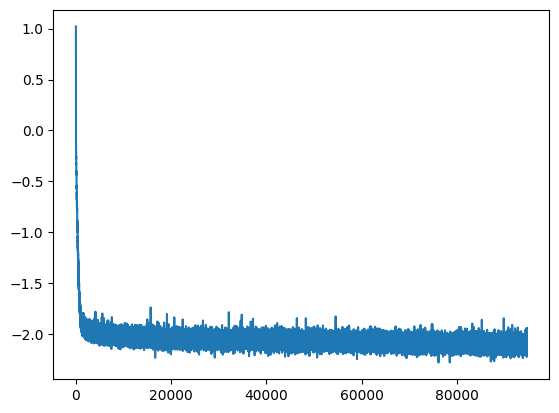

In [7]:
rectified_flow_1 = train(rectified_flow_1, False, optimizer_1, scheduler_1, train_dataloader, get_samples, device, epochs=800, noise_factor=0.005)
plt.plot(np.log(rectified_flow_1.loss_curve))
plt.show()

In [23]:
rectified_flow_1.v_model.eval()

U_Net_big(
  (NN): ModuleDict(
    (contr_1): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): ReLU()
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (contr_2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): ReLU()
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (contr_3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): BatchNorm2d(256, eps=1e-05, mo

In [8]:
torch.save(rectified_flow_1, "./models/MNIST/MNIST_All_Unet.pth")

In [6]:
rectified_flow_1 = torch.load("./models/MNIST/MNIST_All_Unet.pth")

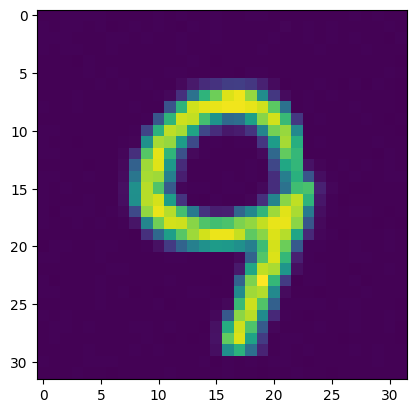

In [20]:
rectified_flow_1.v_model.eval()
img_init = torch.randn(2,1,32,32).to(device)

img = rectified_flow_1.sample_ode(img_init, 100)

plt.imshow(img[-1][0, 0].detach().cpu().numpy())
plt.show()

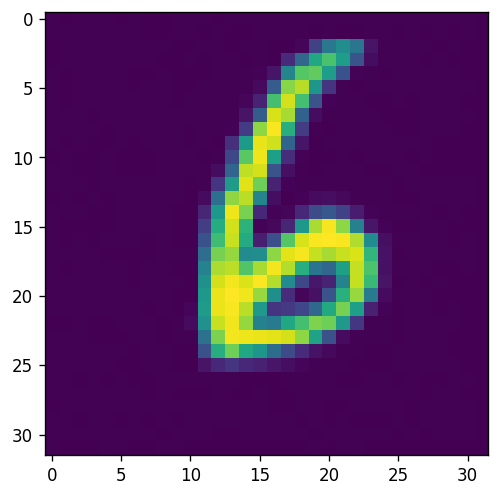

In [173]:
img = rectified_flow_1.sample_ode(img_init, 20)

plt.imshow(img[-1][0, 0].detach().cpu().numpy())
plt.show()

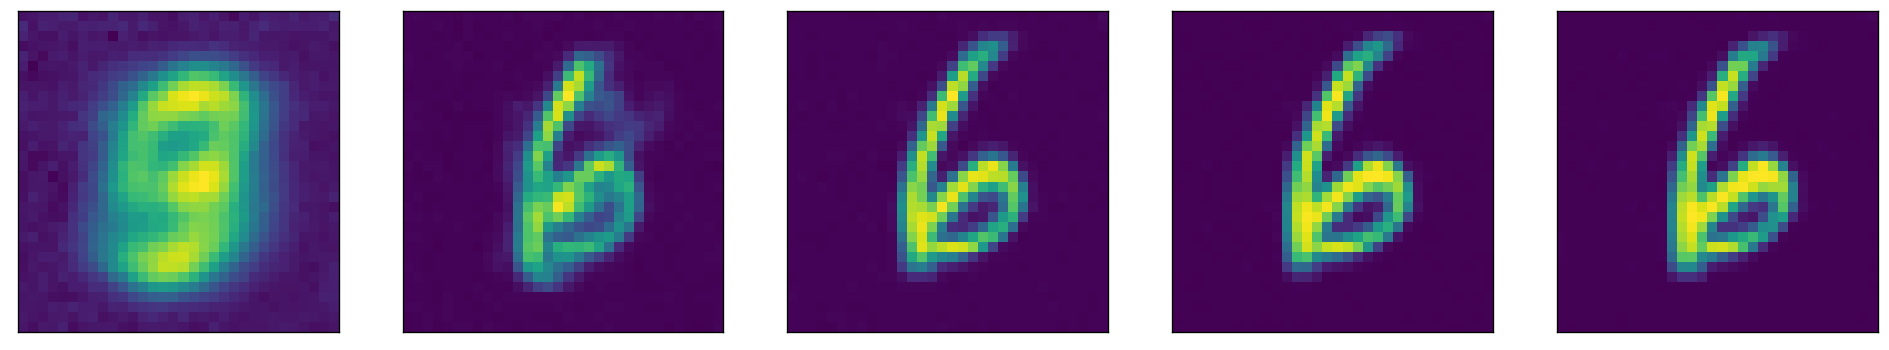

In [177]:
plt.rcParams['figure.dpi'] = 120
rectified_flow_1.v_model.eval()

size = (4*5, 4*1)
fig, ax = plt.subplots(1, 5, figsize=(size),
                        sharex=True, sharey=True)

for row in range(1):
    for column in range(5):
        i = row * 5 + column
        img = rectified_flow_1.sample_ode(img_init, i+1)[-1]
        min = torch.min(img[0])
        img[0] = img[0] - min
        max = torch.max(img[0])
        img[0] = img[0] / max
        ax[column].imshow(
            img[0].permute(1,2,0).detach().cpu().numpy())

plt.xticks([])
plt.yticks([])
plt.show()

In [9]:
samples = [0,0,0,200,0,0,0,0,0,0]

In [167]:
samples[6] = img_init[:1]
for sample in samples:
    print(sample)

tensor([[[[ 0.9375, -1.2797, -1.9427,  ...,  0.6327,  0.1353,  0.3949],
          [ 0.0276,  0.4560, -0.2062,  ...,  0.4278, -2.6911, -1.4483],
          [-0.1761, -0.2068,  0.0320,  ...,  0.8883,  1.1213, -1.8659],
          ...,
          [-0.9525, -1.3963,  0.0622,  ...,  0.8221,  0.1309, -0.0576],
          [ 0.9694, -0.9139,  1.1460,  ..., -1.4975,  0.1004, -0.3728],
          [ 0.8050,  0.9341, -1.1765,  ..., -0.2663, -1.3165, -0.2911]]]],
       device='cuda:0')
tensor([[[[-0.7135, -0.8290,  1.4018,  ...,  0.0364,  0.2482, -1.7617],
          [-1.9803, -0.8343, -1.0952,  ..., -0.1491,  0.4148, -0.5391],
          [ 0.2990,  0.9554, -2.8014,  ..., -0.5713,  0.1817,  1.2450],
          ...,
          [-0.3814, -0.4645,  1.4888,  ...,  0.2164,  0.2807,  0.7891],
          [ 0.7151, -0.5088, -0.2454,  ...,  0.0928, -1.6847,  0.2221],
          [-0.6775,  1.1433,  1.1559,  ..., -0.0280, -1.0075, -0.4750]]]],
       device='cuda:0')
tensor([[[[ 1.4780, -0.1159,  1.2570,  ..., -1.1174,

In [125]:
def show_samples_array(rectified_flow, samples, rows, columns, num_steps, device, conditional=False):
    plt.rcParams['figure.dpi'] = 120
    rectified_flow.v_model.eval()

    size = (4*columns, 4*rows)
    fig, ax = plt.subplots(rows, columns, figsize=(size),
                           sharex=True, sharey=True)

    for row in range(rows):
        for column in range(columns):
            i = row * columns + column
            img = rectified_flow.sample_ode(samples[i], num_steps)[-1]
            min = torch.min(img[0])
            img[0] = img[0] - min
            max = torch.max(img[0])
            img[0] = img[0] / max
            ax[row, column].imshow(
                img[0].permute(1,2,0).detach().cpu().numpy())
    
    plt.xticks([])
    plt.yticks([])
    plt.show()

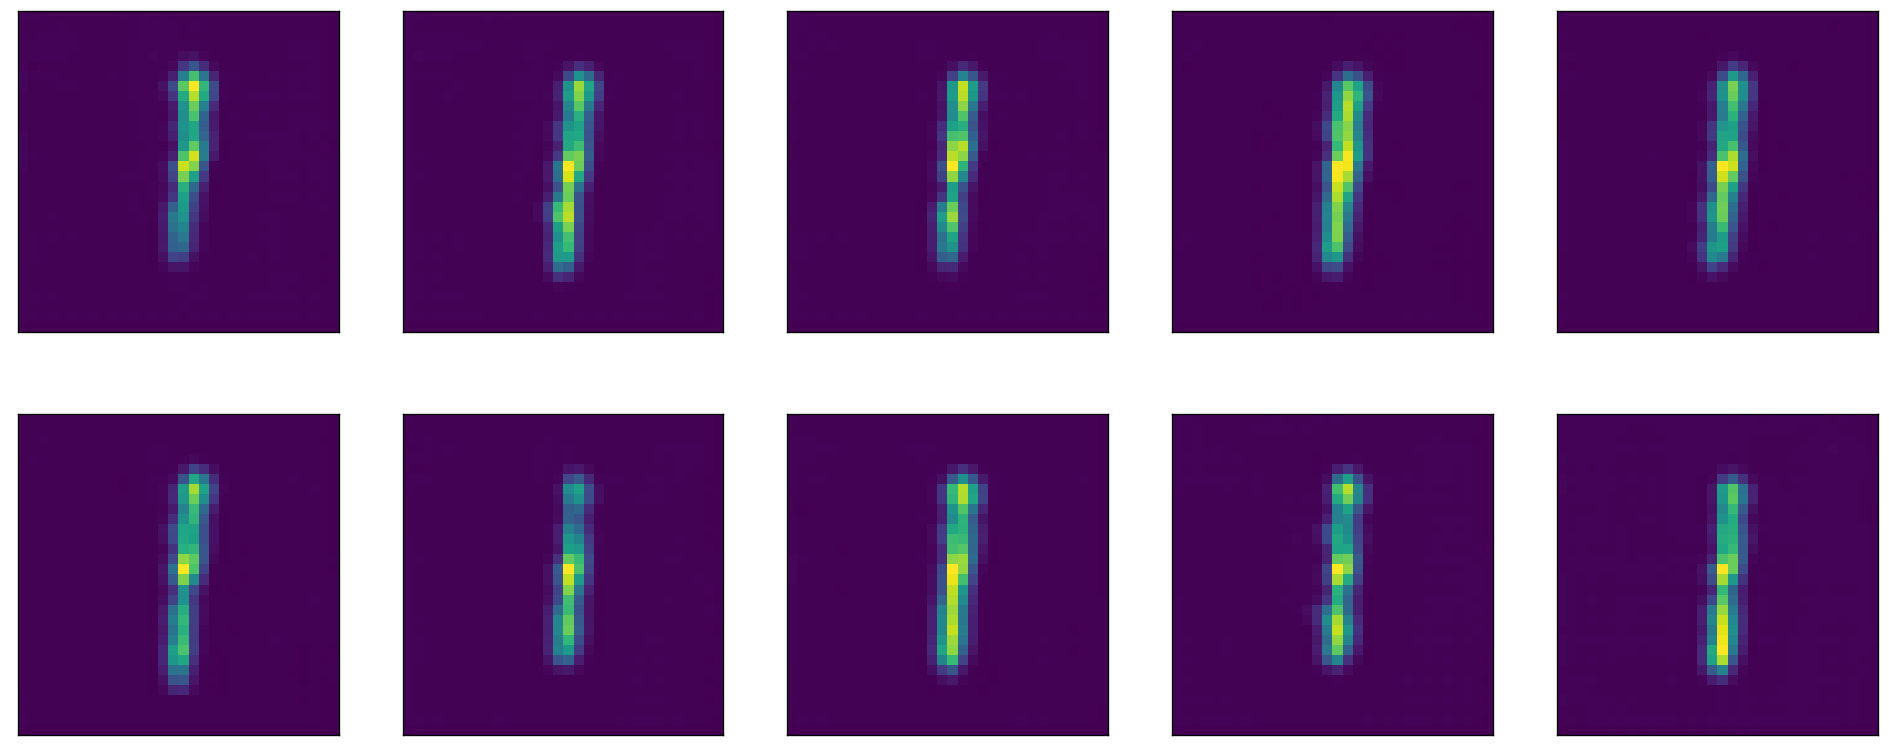

In [144]:
show_samples_array(rectified_flow_1, samples, 2, 5, 100, device)

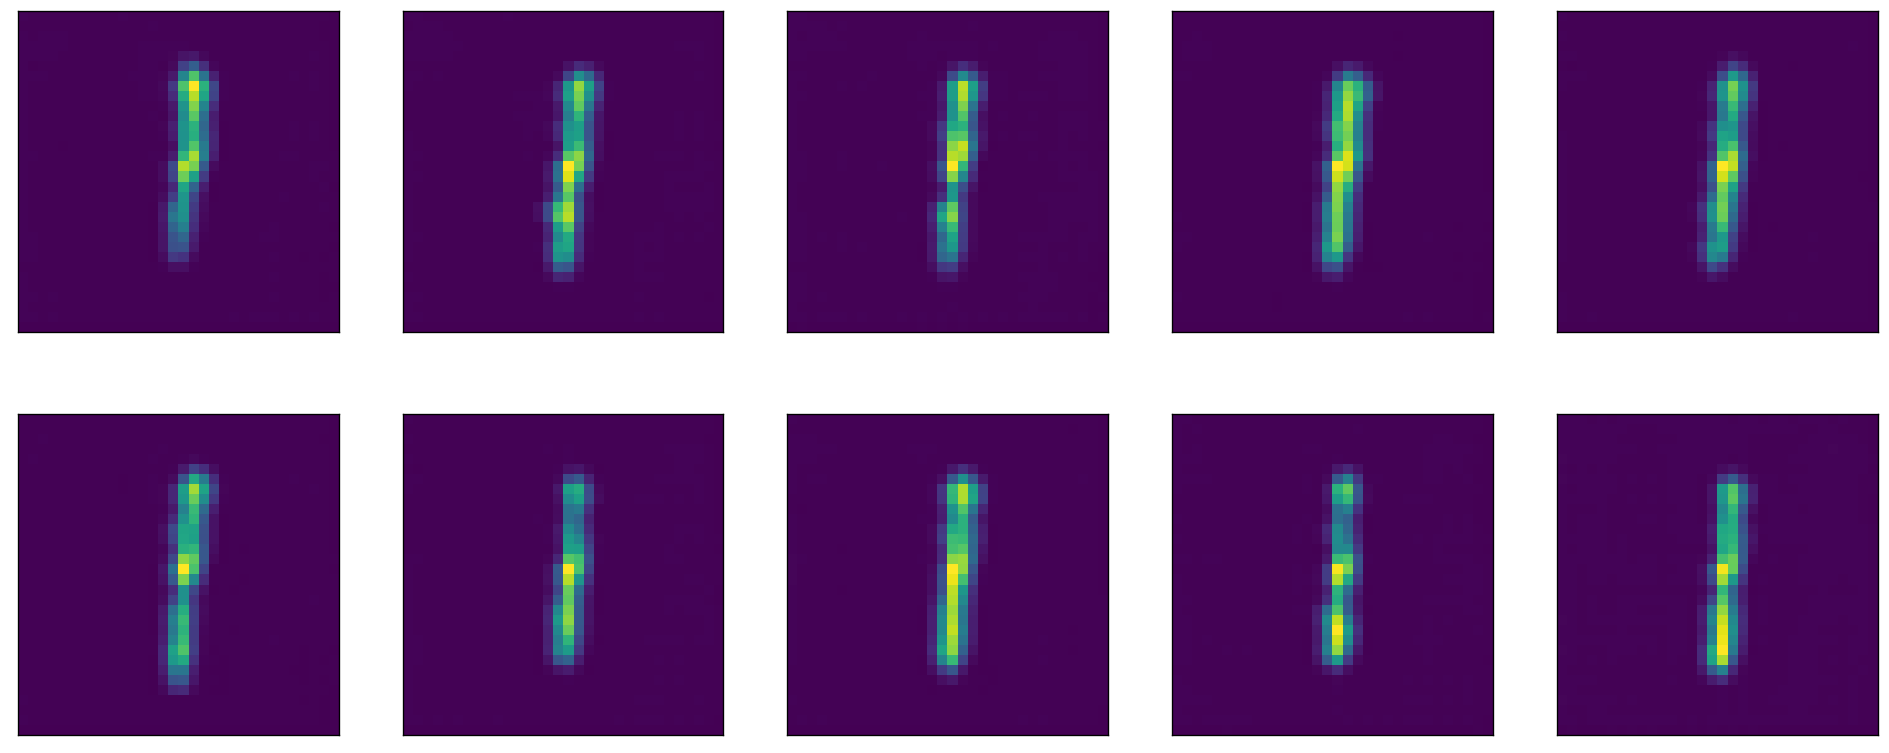

In [126]:
show_samples_array(rectified_flow_1, samples, 2, 5, 100, device)

In [7]:
def show_sample_temperature(rectified_flow, get_samples, rows, columns, channels, img_size, num_steps, device, conditional=False):
    plt.rcParams['figure.dpi'] = 120
    rectified_flow.v_model.eval()
    img_init = get_samples(
        (1, channels, img_size, img_size), device=device)

    size = (4*columns, 4*rows)
    fig, ax = plt.subplots(rows, columns, figsize=(size),
                           sharex=True, sharey=True)

    n = rows * columns

    for row in range(rows):
        for column in range(columns):
            i = row * columns + column
            img = rectified_flow.sample_ode(img_init * (1/n) * i, num_steps)[-1]
            min = torch.min(img[0])
            img[0] = img[0] - min
            max = torch.max(img[0])
            img[0] = img[0] / max
            ax[row, column].imshow(
                img[0].permute(1,2,0).detach().cpu().numpy(), cmap="gray")
    
    plt.xticks([])
    plt.yticks([])
    plt.show()

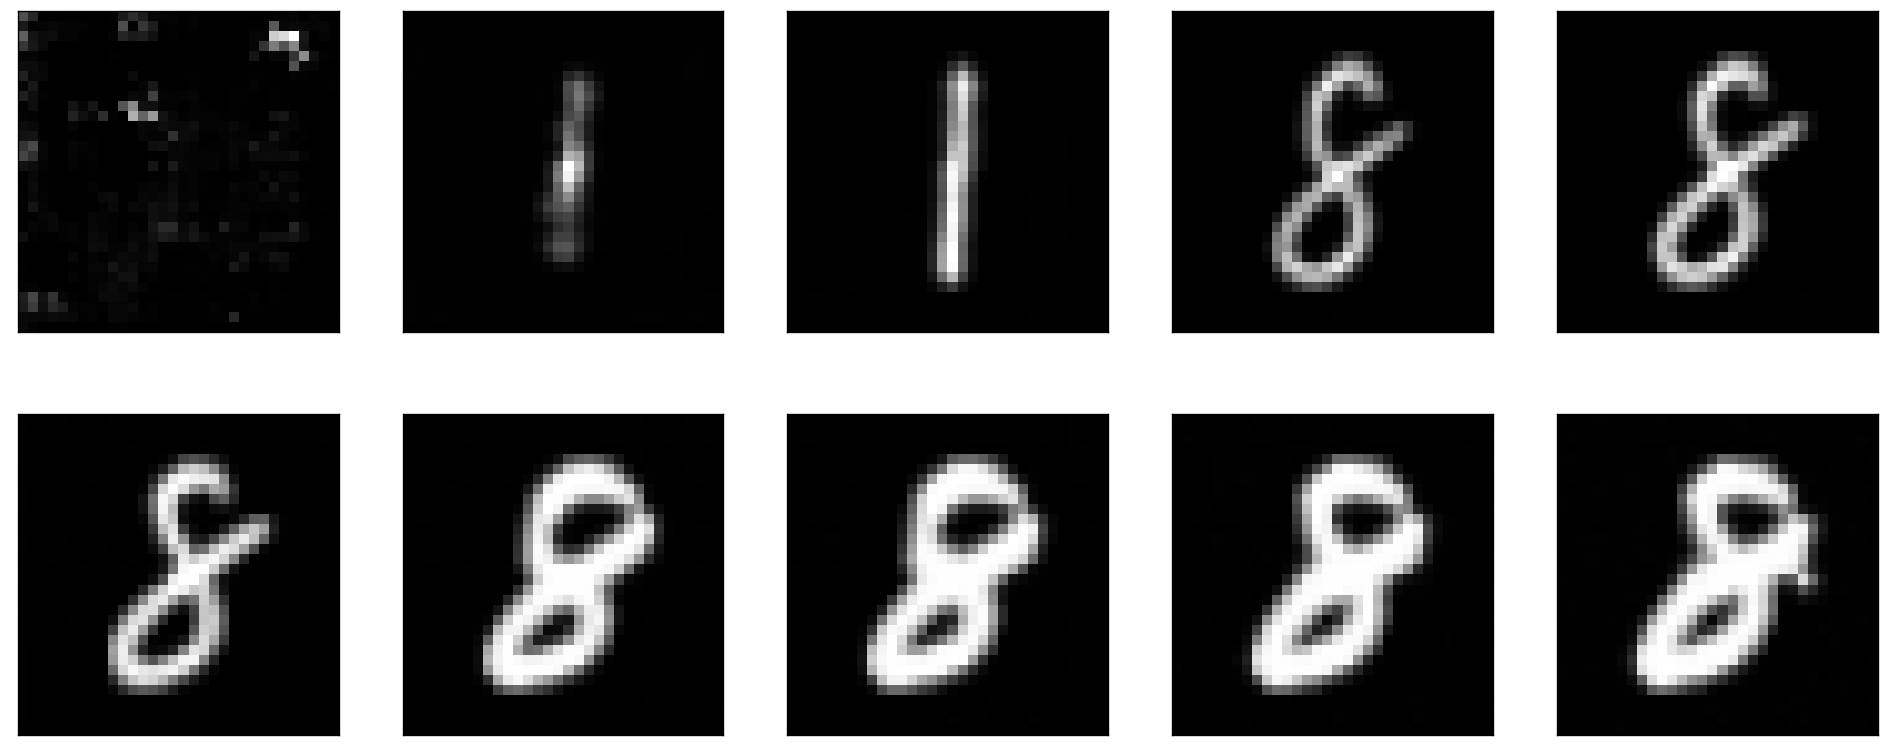

In [8]:
show_sample_temperature(rectified_flow_1, get_samples, 2, 5, 1, 32, 100, device)

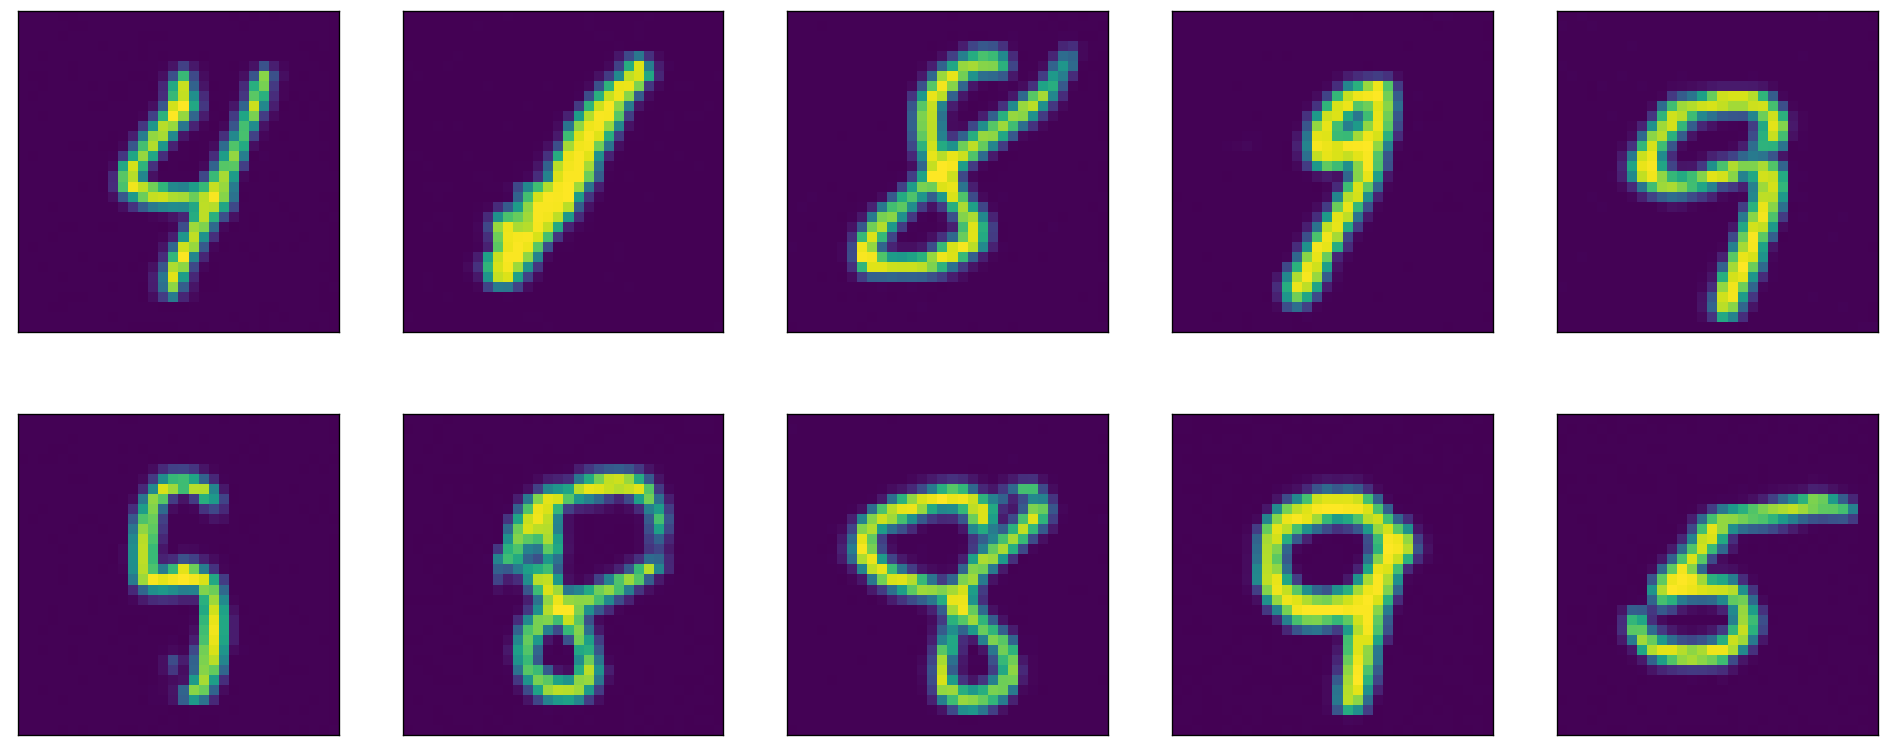

In [5]:
show_samples(rectified_flow_1, get_samples, rows=2, columns=5, channels=1, img_size=32, num_steps=10, device=device)

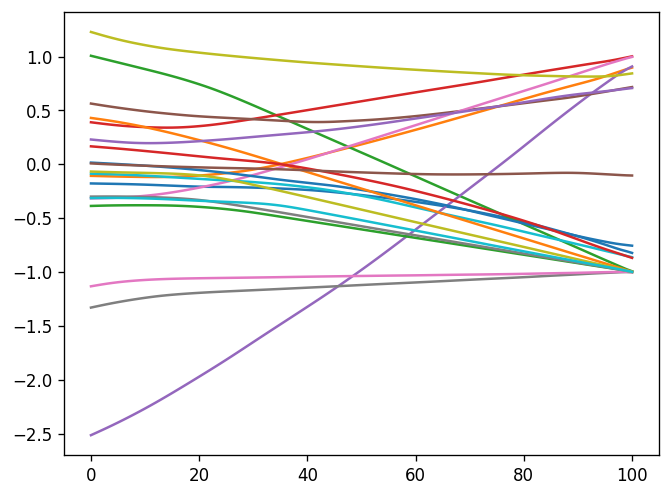

In [135]:
show_trajectories(rectified_flow_1, get_samples, img_size=32, num_steps=100, device=device)